In [1]:
import librosa
import librosa.display

import matplotlib 
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import IPython.display as ipd

from scipy.fft import fft

import numpy as np

from andatum_rene_sandbox import andatum as adt

import sounddevice as sd

In [2]:
song = adt("../data/external/Ralf Reuvers - Andata.wav")

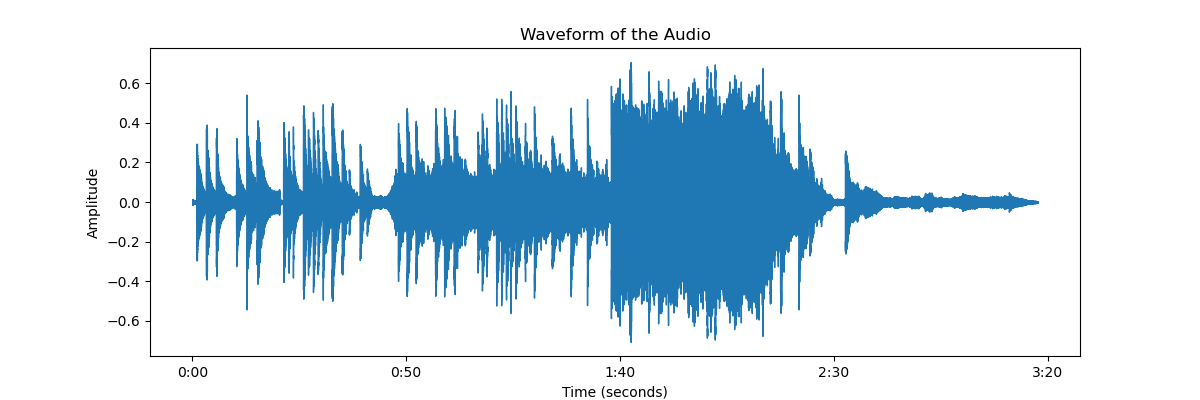

In [3]:
# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(song.tseries, sr=song.sr)
plt.title("Waveform of the Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# ipd.Audio(song.filepath)

In [5]:
# Compute FFT of the entire signal
fft_spectrum = np.abs(fft(song.tseries))

# Get frequencies
freqs = np.fft.fftfreq(len(fft_spectrum), 1/song.sr)

In [6]:
# Keep only positive frequencies
positive_freqs = freqs[:len(freqs)//2]
positive_fft_spectrum = fft_spectrum[:len(freqs)//2]

In [7]:
# Compute total energy
total_energy = np.sum(positive_fft_spectrum)

# Compute cumulative energy distribution
sorted_magnitudes = np.sort(positive_fft_spectrum)[::-1]  # Sort in descending order
cumulative_energy = np.cumsum(sorted_magnitudes) / total_energy  # Normalize

# Find frequency cutoff where 95% of the energy is retained
threshold = 0.95  # 95% energy threshold
cutoff_index = np.argmax(cumulative_energy >= threshold)

# Get the corresponding frequency range
important_freq_range = positive_freqs[:cutoff_index]

print(f"Important frequency range: 0 - {important_freq_range[-1]:.2f} Hz")

Important frequency range: 0 - 3479.46 Hz


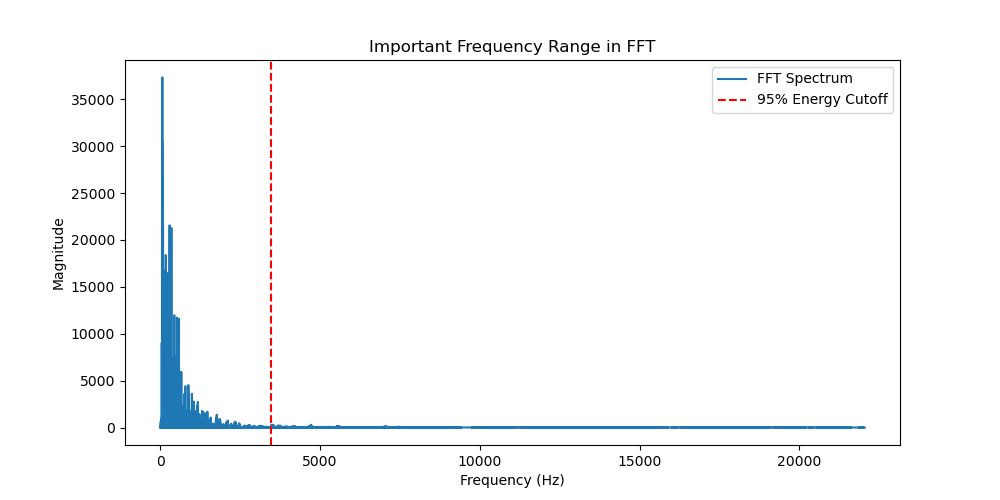

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, positive_fft_spectrum, label="FFT Spectrum")
plt.axvline(important_freq_range[-1], color="red", linestyle="--", label="95% Energy Cutoff")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Important Frequency Range in FFT")
plt.legend()
plt.show()

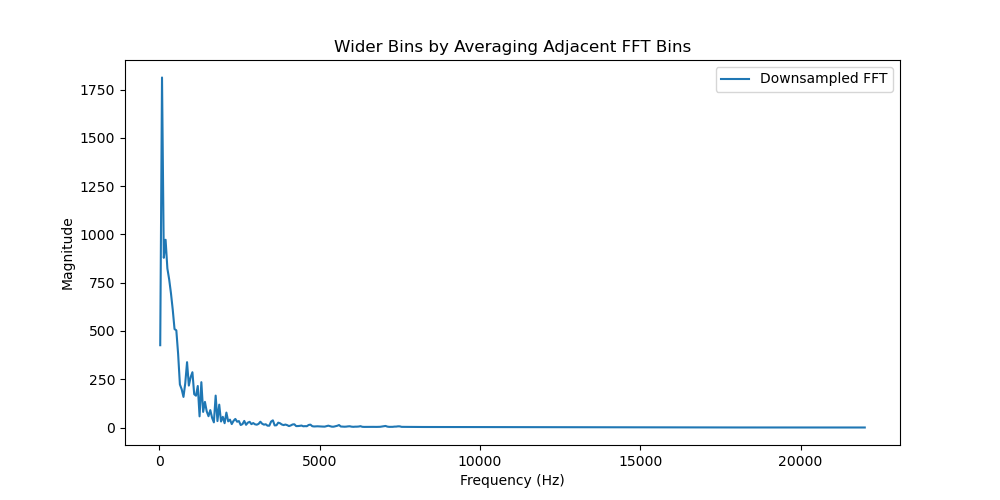

In [9]:
import numpy as np

# Define bin width (e.g., group every 10 bins into one)
bin_width = 11025

# Ensure the length of positive_freqs is a multiple of bin_width
trim_length = len(freqs[:len(freqs)//2]) // bin_width * bin_width
positive_freqs = freqs[:trim_length].reshape(-1, bin_width).mean(axis=1)
positive_fft_spectrum = fft_spectrum[:trim_length].reshape(-1, bin_width).mean(axis=1)

# Plot the downsampled spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, positive_fft_spectrum, label="Downsampled FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Wider Bins by Averaging Adjacent FFT Bins")
plt.legend()
plt.show()

In [10]:
import numpy as np

# Find indices of the most dominant frequencies
top_n = 5  # Number of top frequencies to extract
top_indices = np.argsort(positive_fft_spectrum)[-top_n:]  # Indices of top N peaks

# Extract the corresponding frequencies and magnitudes
top_frequencies = positive_freqs[top_indices]
top_magnitudes = positive_fft_spectrum[top_indices]

# Print results
for f, mag in zip(top_frequencies, top_magnitudes):
    print(f"Frequency: {f:.2f} Hz, Magnitude: {mag:.2f}")

Frequency: 306.75 Hz, Magnitude: 766.97
Frequency: 250.98 Hz, Magnitude: 823.42
Frequency: 139.43 Hz, Magnitude: 878.82
Frequency: 195.20 Hz, Magnitude: 972.25
Frequency: 83.66 Hz, Magnitude: 1812.54


In [11]:
print(song.sr/4)

11025.0


**For a Soothing Experience**
- Combine frequencies in the 20 Hz – 200 Hz range for visually smooth and musically calming effects.
- Use harmonic relationships (e.g., 50 Hz + 100 Hz + 150 Hz) to create aesthetically pleasing beats and wave interference patterns.
- Apply a slight amplitude modulation or phase shift to create visually dynamic and organic motion.

Resampling from 44100 Hz to 48000.0 Hz
48000.0


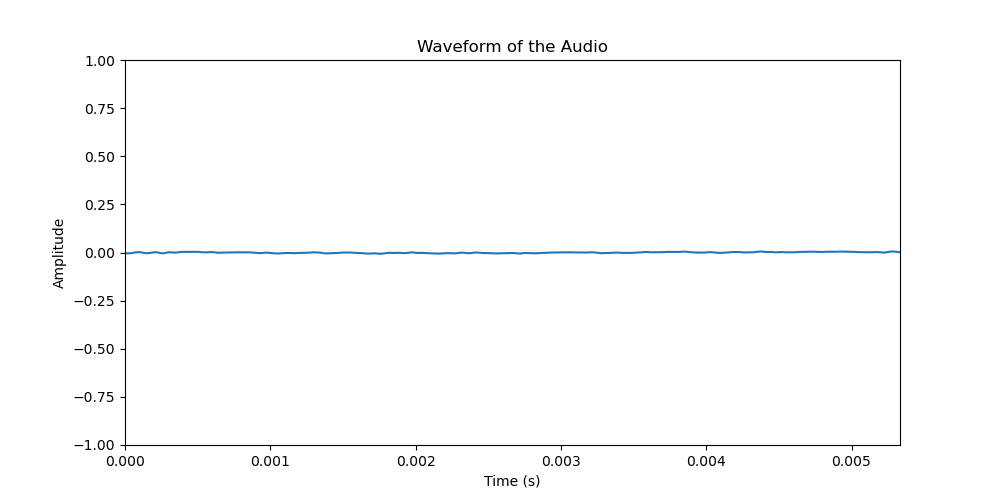

In [22]:
song = adt("../data/external/Ralf Reuvers - Andata.wav")

# Check if the sample rate is supported
output_device_info = sd.query_devices(sd.default.device['output'], 'output')
supported_sample_rate = output_device_info['default_samplerate']

if song.sr != supported_sample_rate:
    print(f"Resampling from {song.sr} Hz to {supported_sample_rate} Hz")
    song.tseries = librosa.resample(song.tseries, orig_sr=song.sr, target_sr=supported_sample_rate)
    song.sr = supported_sample_rate
    print(song.sr)

# Function to play audio
def play_audio(data, sample_rate):
    sd.play(data, sample_rate)

# Function to update the plot
def update_plot(frame):
    global start_idx
    end_idx = start_idx + window_size
    if end_idx > len(song.tseries):
        end_idx = len(song.tseries)
    line.set_ydata(song.tseries[start_idx:end_idx])
    start_idx += hop_size
    return line,

# Parameters for the dynamic plot
window_size = 256  # Number of samples to display at a time
hop_size = 64  # Number of samples to advance for each frame
start_idx = 0

song_duration = len(song.tseries) / song.sr  # Duration of the song in seconds
num_frames = len(range(0, len(song.tseries), hop_size))  # Number of frames in the animation
interval = (song_duration / num_frames) * 1000  # Interval in milliseconds

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 5))
time = np.linspace(0, window_size / song.sr, num=window_size)
line, = ax.plot(time, song.tseries[:window_size])
ax.set_xlim(0, window_size / song.sr)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Waveform of the Audio")

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=range(0, len(song.tseries), hop_size), blit=True, interval=(1000/30))

# Play the audio
play_audio(song.tseries, song.sr)

# Show the plot
plt.show()

In [23]:
sd.stop()
ani.event_source.stop()
ani = None

In [30]:
# Calculate the interval value
song_duration = len(song.tseries) / song.sr  # Duration of the song in seconds
num_frames = len(range(0, len(song.tseries), hop_size))  # Number of frames in the animation
interval = (song_duration / num_frames) * 1000  # Interval in milliseconds
print(interval)

10.666151819277324


In [18]:
window_size = 256  # Number of samples to display at a time
hop_size = 128  # Number of samples to advance for each frame
start_idx = 0
song_duration = len(song.tseries) / song.sr  # Duration of the song in seconds
num_frames = len(range(0, len(song.tseries), hop_size))  # Number of frames in the animation
print(f"song duration {song_duration}, number of frames {num_frames}")
print(f"frame rate = {num_frames/song_duration}")

song duration 197.67579166666667, number of frames 74129
frame rate = 375.0029246120383


1. Extract the timeseries amplitude of a target frequency for the song 
2. Define a hop size and window size combination that produces the minimum acceptable resolution sinusoid animations
3. Define the length of the series required to achieve 30fps for the length of the song and hop size
4. Use this to downsample the song to the target length of the time series 

In [14]:
ani.event_source.stop()
ani = None

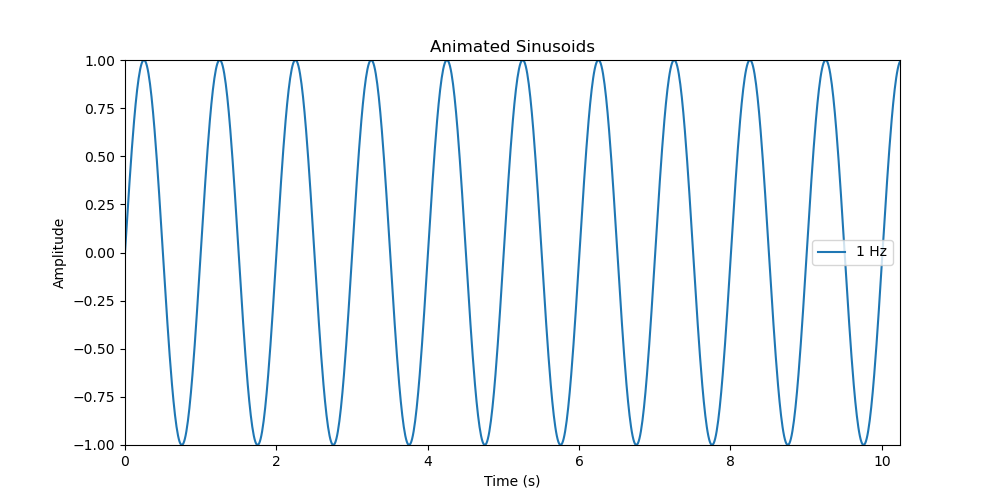

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (784,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (272,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1024,) and arg 1 with shape (0,).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Parameters for the sinusoids
frequencies = [1]  # Frequencies of the sinusoids in Hz
amplitude = 1  # Amplitude of the sinusoids
duration = 100  # Duration of the sinusoids in seconds
sample_rate = 100  # Sample rate in Hz

# Generate time array
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate sinusoids
sinusoids = [amplitude * np.sin(2 * np.pi * f * t) for f in frequencies]

# Function to update the plot
def update_plot(frame):
    global start_idx
    end_idx = start_idx + window_size
    if end_idx > len(t):
        end_idx = len(t)
    for i, line in enumerate(lines):
        line.set_ydata(sinusoids[i][start_idx:end_idx])
    start_idx += hop_size
    return lines

# Parameters for the dynamic plot
window_size = 1024  # Number of samples to display at a time
hop_size = 256  # Number of samples to advance for each frame
start_idx = 0

# Ensure window_size does not exceed the length of the sinusoids array
window_size = min(window_size, len(t))

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 5))
time = np.linspace(0, window_size / sample_rate, num=window_size)
lines = [ax.plot(time, sinusoids[i][:window_size], label=f'{frequencies[i]} Hz')[0] for i in range(len(frequencies))]
ax.set_xlim(0, window_size / sample_rate)
ax.set_ylim(-amplitude, amplitude)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Animated Sinusoids")
ax.legend()

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=range(0, len(t), hop_size), blit=True, interval=1000/30)

# Show the plot
plt.show()